# Portfolio 2: Analysing COVID-19 Data

For the second portfolio we'll look at the most relevant dataset to our lives at the moment: the global spread of COVID-19.   There is an open dataset avaialable that is updated often showing the number of cases in different regions of the world.  This is the source of the graphs and visualisations that you'll see on the news. 

Here are some sample stories for reference:

* [From the ABC](https://www.abc.net.au/news/2020-03-26/coronavirus-covid19-global-spread-data-explained/12089028)
* [From the Guardian](https://www.theguardian.com/australia-news/datablog/ng-interactive/2020/apr/06/coronavirus-cases-in-australia-map-curve-confirmed-numbers-stats-how-many-covid-19-nsw-by-postcode-maps-victoria-live-data-qld-sa-wa-tas-nt-act-latest-statistics)
* [Coronavirus in Australia](https://www.covid19data.com.au/)
* [ArcGIS Dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) Johns Hopkins


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
%matplotlib inline

## Getting the Data

The first step is to get a copy of the raw data.  The data is being made available by Johns Hopkins University in [this GitHub repository](https://github.com/CSSEGISandData/COVID-19). We're interestd in the global confirmed cases dataset but you can also get data on deaths and recovered cases.  

You can either download a copy of the data into your project or just read it from the URL. The advantage of reading the URL is that you'll get live updates, but this might make it harder for you to repeat your experiments if the data changes.  Also, you would be making new requests for data every time you ran your worksheet putting load on the server (and your own network connection).  Consider downloading a copy as you are developing your worksheet and then switching to the live version once everything is debugged. (Eg. you could clone the github repository and copy the relevant data file into this project).

In [2]:
# loading the dataset
covid = pd.read_csv('data/time_series_covid19_confirmed_global.csv')

In [3]:
covid.head(10).T

,0,1,2,3,4,5,6,7,8,9
Province/State,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Australian Capital Territory,New South Wales
Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Australia
Lat,33,41.1533,28.0339,42.5063,-11.2027,17.0608,-38.4161,40.0691,-35.4735,-33.8688
Long,65,20.1683,1.6596,1.5218,17.8739,-61.7964,-63.6167,45.0382,149.012,151.209
1/22/20,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
4/9/20,484,409,1666,583,19,19,1795,921,100,2773
4/10/20,521,416,1761,601,19,19,1975,937,103,2822
4/11/20,555,433,1825,601,19,21,1975,967,103,2857
4/12/20,607,446,1914,638,19,21,2142,1013,103,2857


## Exploring the Data

The format of this data is one row per geographical region with columns for Lat/Long and then one column for each day's data.  Most regions are countries but in some cases, as in Australia, they are states.  

For the analysis we want to do we'll look at data for countries only, so the first operation on the data frame is to combine all of the rows for countries like Australia that are split into states.  We then want to drop the non-numeric columns to leave us with just the numbers on each day for each country.  This can be done using the [`groupby`](https://pandas.pydata.org/docs/getting_started/10min.html#grouping) method and the [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) method.  We can use these to make a new dataframe containing just the numerical data.

In [4]:
covid['Country/Region'].value_counts()

China             33
Canada            15
United Kingdom    11
France            11
Australia          8
                  ..
Austria            1
Ecuador            1
Norway             1
Brunei             1
Egypt              1
Name: Country/Region, Length: 185, dtype: int64

To figure out which countries having the states in country/region variable we are counting the values of each country. We can see that Australia is having 8.

In [5]:
# grouping the states & dropping the lat and long columns
grouped = covid.groupby('Country/Region').sum()
grouped = grouped.drop(columns=['Lat', 'Long'])
grouped.head(12).T

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas
1/22/20,0,0,0,0,0,0,0,0,0,0,0,0
1/23/20,0,0,0,0,0,0,0,0,0,0,0,0
1/24/20,0,0,0,0,0,0,0,0,0,0,0,0
1/25/20,0,0,0,0,0,0,0,0,0,0,0,0
1/26/20,0,0,0,0,0,0,0,0,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4/9/20,484,409,1666,583,19,19,1795,921,6108,13244,926,41
4/10/20,521,416,1761,601,19,19,1975,937,6215,13555,991,42
4/11/20,555,433,1825,601,19,21,1975,967,6303,13806,1058,46
4/12/20,607,446,1914,638,19,21,2142,1013,6315,13945,1098,46


Here we are grouping the states for each country and dropping the columns which are not required in this analysis such as latitude and longitude.

In [6]:
grouped.index.value_counts()

Diamond Princess        1
Algeria                 1
South Africa            1
Czechia                 1
Canada                  1
                       ..
Indonesia               1
Austria                 1
United Arab Emirates    1
Norway                  1
Egypt                   1
Name: Country/Region, Length: 185, dtype: int64

Now we can see that the countries having states are grouped and having values of 1.

Now we can just select the data for one country [using the `loc` method](https://pandas.pydata.org/docs/getting_started/10min.html#selection) since the new dataframe will have the grouped values (Countries) as the row labels. Selecting the data for one country and plotting it. We can see the exponential rise in case numbers over time.

In [7]:
# creating dataframe for cases in USA
df_USA = pd.DataFrame()
df_USA['Confirmed Cases'] = grouped.loc['US']
df_USA['Date'] = df_USA.index
df_USA.tail()

,Confirmed Cases,Date
4/9/20,461437,4/9/20
4/10/20,496535,4/10/20
4/11/20,526396,4/11/20
4/12/20,555313,4/12/20
4/13/20,580619,4/13/20


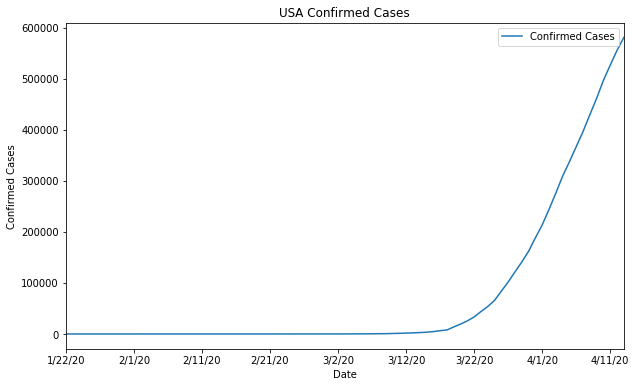

In [8]:
# plot for cases in Australia
df_USA.plot.line(figsize = (10,6), x = 'Date')
plt.ylabel('Confirmed Cases')
plt.title('USA Confirmed Cases')
plt.show()

There is an exponential rise in the cases in USA particularly from the middle of the third month.

## Comparing Countries

One of the classic displays in the news is the comparison between countries.  Selecting a number of countries and plotting their data on the same graph to reproduce this visualisation. Suitable countries would be those who have significant outbreaks - China, USA, Italy, UK, Australia. 

In [9]:
# Creating DataFrame for countries
df = pd.DataFrame()
df['Australia'] = grouped.loc['Australia']
df['China'] = grouped.loc['China']
df['USA'] = grouped.loc['US']
df['UK'] = grouped.loc['United Kingdom']
df['Italy'] = grouped.loc['Italy']
df['India'] = grouped.loc['India']
df['Date'] = df.index
df.tail()

,Australia,China,USA,UK,Italy,India,Date
4/9/20,6108,82883,461437,65872,143626,6725,4/9/20
4/10/20,6215,82941,496535,74605,147577,7598,4/10/20
4/11/20,6303,83014,526396,79874,152271,8446,4/11/20
4/12/20,6315,83134,555313,85206,156363,9205,4/12/20
4/13/20,6351,83213,580619,89570,159516,10453,4/13/20


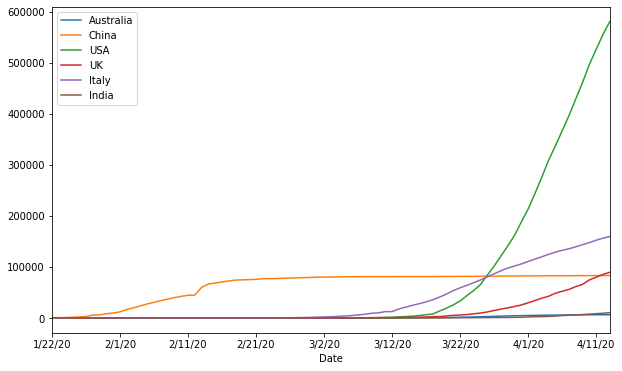

In [10]:
# plotting for various countries
df.plot.line(figsize = (10,6), x = 'Date')
plt.show()

By comparing the countries, the cases in china had started decreasing and the cases in USA is increasing with an exponential rise. The countries such as UK and Italy are also showing an exponential rise and having significant outbreaks.

**Challenge**: A very useful visualisation shows the data for different countries aligned from the time that they have 100 confirmed cases. To create this figure, we need to take only the part of each time series after the value is greater than or equal to 100 and then plotting this starting at 0 on the x-axis.  This is a bit more involved but will allow us to explore Pandas a bit more.

In [11]:
# Creatting a dataframe for choosen countries
df2 = df.reset_index(drop=True)
df2 = df2.drop(columns = ['Date'])
df2

,Australia,China,USA,UK,Italy,India
0,0,548,1,0,0,0
1,0,643,1,0,0,0
2,0,920,2,0,0,0
3,0,1406,2,0,0,0
4,4,2075,5,0,0,0
...,...,...,...,...,...,...
78,6108,82883,461437,65872,143626,6725
79,6215,82941,496535,74605,147577,7598
80,6303,83014,526396,79874,152271,8446
81,6315,83134,555313,85206,156363,9205


In [12]:
# countries having cases greater than or equal to hundred
cols = ['Australia','China','USA','UK','Italy','India']
df2[cols] = df2[df2[cols] >= 100][cols]

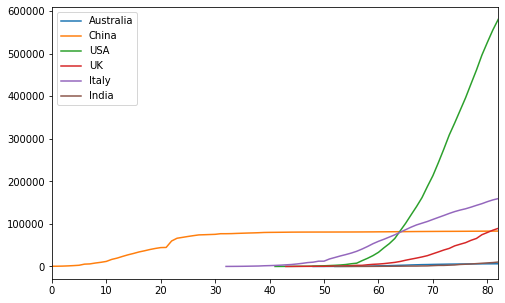

In [13]:
df2.plot(figsize = (8,5))
plt.show()

The above plot shows us the countries from the time that they have 100 confirmed cases, here we are taking only the part of each time series after the value is greater than or equal to 100.

## Normalisation by Population

The raw data includes the overall count of cases in each country. Clearly small countries will have smaller overall values than large countries.  It would be interesting to see whether the number of cases in China and the US was more per-capita than those in other countries and find which country has the highest number as a proportion of the population. (A good way to measure this is the number of cases per million people in the population. If a country has 25 cases and a population of 2.5 million they would have 10 cases per million).

We need population data. Here we are having two possible sources of data (there are more of course) [datahub.io](https://datahub.io/JohnSnowLabs/population-figures-by-country) has data per country up to 2016 in a handy CSV format. The [United Nations Population Dynamics page](https://population.un.org/wpp/Download/Standard/CSV/) has data that predicts populations up to 2100 in CSV format.  Use one of these data sets to compute the number of confirmed cases for each country per million population.   Creating a new plot with this data. Creating a plot to compare the most recent day's data - which country has the most cases per million right now? 

_Note, to use the population data we will have to make sure that the country names match up in the different data sets. There's no magic way to do this, either we edit one of the datasets or writing code to modify the data once you read it in.  The second of these is better because it makes it easy for someone else to repeat the analysis._

In [14]:
# reading the population data set
population = pd.read_csv('data/population-figures-by-country.csv')
population = population.set_index('Country')
population.head()

,Country_Code,Year_1960,Year_1961,Year_1962,Year_1963,Year_1964,Year_1965,Year_1966,Year_1967,Year_1968,...,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016
Country,,,,,,,,,,,,,,,,,,,,,
Aruba,ABW,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,57715.0,58055.0,58386.0,...,101220.0,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0
Afghanistan,AFG,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,10152331.0,10372630.0,10604346.0,...,26616792.0,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0
Angola,AGO,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,6309770.0,6414995.0,6523791.0,...,20997687.0,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0
Albania,ALB,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,1965598.0,2022272.0,...,2970017.0,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0
Andorra,AND,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,19647.0,20758.0,21890.0,...,82683.0,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0


In [15]:
# population in the Year 2016 for different countries
df_pop_Aus = population.loc['Australia','Year_2016']
df_pop_China= population.loc['China','Year_2016']
df_pop_USA= population.loc['US','Year_2016']
df_pop_UK= population.loc['United Kingdom','Year_2016']
df_pop_Italy = population.loc['Italy','Year_2016']
df_pop_India = population.loc['India','Year_2016']

Here we are collecting the population data for our chosen countries in the year 2016 from the population dataset using loc method.

In [16]:
# cases in countries on 4/13/20
df_case_Aus = grouped.loc['Australia','4/13/20']
df_case_China= grouped.loc['China','4/13/20']
df_case_USA= grouped.loc['US','4/13/20']
df_case_UK= grouped.loc['United Kingdom','4/13/20']
df_case_Italy = grouped.loc['Italy','4/13/20']
df_case_India = grouped.loc['India','4/13/20']

In this step we are choosing the confirmed cases in countries which ever is latest.

In [17]:
# creating dataframe for countries,cases and population
d = {'Country': ['Australia', 'China', 'USA', 'UK', 'Italy', 'India'], 'Cases': [df_case_Aus,df_case_China,df_case_USA,df_case_UK,df_case_Italy,df_case_India], 'Population': [df_pop_Aus,df_pop_China,df_pop_USA,df_pop_UK,df_pop_Italy,df_pop_India]}
df_total = pd.DataFrame(data = d)

In [18]:
# number of cases per million population
cases_mn = df_total.Cases/(df_total.Population/(1000000))

In [19]:
df_total['Cases/mn'] = cases_mn
df_total

,Country,Cases,Population,Cases/mn
0,Australia,6351,2.412716e+07,263.230329
1,China,83213,1.378665e+09,60.357665
2,USA,580619,3.231275e+08,1796.872679
3,UK,89570,6.563724e+07,1364.621690
4,Italy,159516,6.060059e+07,2632.251600
5,India,10453,1.324171e+09,7.893993


We are using basic math to get the cases per million population which very important in the analysis to check cases per million population.

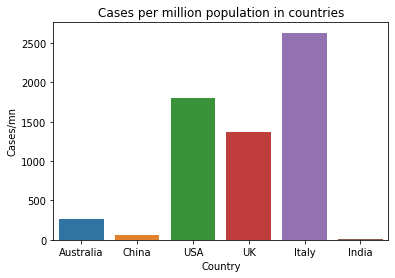

In [20]:
# plotting a bar graph for cases per million population in countries 
sns.barplot(x = 'Country', y = 'Cases/mn', data = df_total).set_title('Cases per million population in countries')
plt.show()

By looking at the bar graph it is clearly shown that Italy is having more number of cases per million population. USA is having more number of cases compared to the other but while checking the cases with the population Italy is having highest which is 2500 cases per million population.

## A Predictive Model

It is well understood that the spread of the virus follows an exponential pattern. This is because each infected person infects more than one new person on average, leading to exponential growth.  This is why the key to stopping the growth of the pandemic is to reduce the number of people infected by stopping contact and isolating infected people. 

An exponential curve has the equation $y = e^{mx}$. It can be converted to a linear relationship by taking the logarithm of each side: $log(y) = mx$.  This means that we can fit a linear regression model to the data as long as we take the log of the number of cases. 

Select a country with a clear exponential curve (for example, the US) and build a linear regression model to predict the log of the number of case.  Test how well the model fits the data. 

Now, select the data from China. This should show some divergence from the model since they have managed to slow the growth of cases.  Can you show from the model that China's data does not show exponential growth?   If China had not acted to stop the virus, how many cases would there be now according to this simple model? 

Can you use this metric to identify countries where the virus is under control and those where it is not? 

In [21]:
df_USA.describe()

,Confirmed Cases
count,83.000000
mean,75641.481928
std,152129.962467
min,1.000000
25%,12.000000
50%,118.000000
75%,48793.500000
max,580619.000000


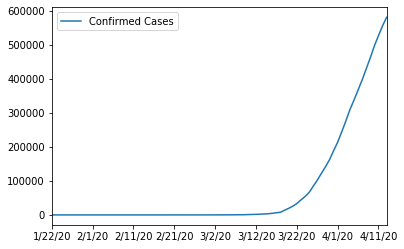

In [22]:
df_USA.plot()
plt.show()

There is an exponential growth in the cases of country USA.

In [23]:
df_USA['log_cases'] = np.log(df_USA['Confirmed Cases'])
df_USA.head()

,Confirmed Cases,Date,log_cases
1/22/20,1,1/22/20,0.000000
1/23/20,1,1/23/20,0.000000
1/24/20,2,1/24/20,0.693147
1/25/20,2,1/25/20,0.693147
1/26/20,5,1/26/20,1.609438


Here we are taking log for the confirmed cases to make it maintain a linear relationship.

The above plot shows us a linear relationship, so we can fit a linear regression model to the data.

In [24]:
X = df_USA[['Confirmed Cases']]
y = df_USA[['log_cases']]

Now we can split the data into train and test set which will be able to check the performance of our model.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train shape:  (62, 1)
y_train shape:  (62, 1)
X_test shape:  (21, 1)
y_test.shape:  (21, 1)


Fitting a linear regression model by giving train set data to analyse.

In [26]:
lr = linear_model.LinearRegression().fit(X_train, y_train)

We can check the performance of our model by looking at the MSE and R-squared values.
The smaller MSE value and the R squared value will be closer to one(100%), then shows us the model is good.

In [27]:
# predicting on train set
y_pred_train = lr.predict(X_train)
mse = ((np.array(y_train)-y_pred_train)**2).sum()/len(y_train)
r2 = r2_score(y_train, y_pred_train)
print("Accuracy on training set:")
print("MSE:", mse)
print("R Squared:", r2)

Accuracy on training set:
MSE: 7.885621061537749
R Squared: 0.5635875252095649


In [28]:
# predicting on test set
y_pred_test = lr.predict(X_test)
mse = ((np.array(y_test)-y_pred_test)**2).sum()/len(y_test)
r2 = r2_score(y_test, y_pred_test)
print("Accuracy on test set:")
print("MSE:", mse)
print("R Squared:", r2)

Accuracy on test set:
MSE: 9.992791626846401
R Squared: 0.4108127137233534


In [29]:
# predicted Value
X = [[700000]]
y_pred = lr.predict(X)
y_pred

array([[19.88365915]])

### pycaret is an open source, low-code machine learning library in Python that allows us to do from preparing the data to deploying our model within seconds. We are using it just to know the features and advantages in pycaret because I am using it for the first time.

In [30]:
import pycaret

In [31]:
from pycaret.regression import *

In [32]:
reg1 = setup(data = df_USA, target = 'Confirmed Cases', train_size = 0.7)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,6088
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(83, 3)"
4,Missing Values,False
5,Numeric Features,1
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [33]:
# comparing all models
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest,9354.29,5.21741e+08,16182.7,0.9236,0.7613,3.9971
1,Extreme Gradient Boosting,8913.99,2.86008e+08,14337.9,0.9212,0.7875,1.5839
2,Gradient Boosting Regressor,9265.81,3.91517e+08,16144.5,0.9164,0.4039,0.5342
3,Decision Tree,11945.8,5.76267e+08,19483,0.9014,0.2498,0.2033
4,K Neighbors Regressor,20135,2.15247e+09,35023.9,0.8124,0.3463,0.3427
5,Support Vector Machine,80360.9,2.92347e+10,137127,-0.4651,4.4642,21.3532
6,CatBoost Regressor,15110.2,8.71172e+08,24259.9,-0.6613,2.9983,210.061
7,Extra Trees Regressor,8308.13,4.81706e+08,14972.3,-0.9692,0.4926,1.0066
8,AdaBoost Regressor,14958.5,4.73186e+08,19644.7,-9.0216,4.1544,457.051
9,Light Gradient Boosting Machine,53662.8,6.39844e+09,69854.3,-71.8257,5.0023,909.147


In [44]:
# creating linear regression model
lr = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,32708.2674,1.143713e+09,33818.8241,-1837.1719,6.5839,2186.0951
1,46885.8250,3.700167e+09,60828.9993,0.6922,4.0190,443.7686
2,103416.9333,1.950006e+10,139642.6075,-1.2656,1.4150,4.3693
3,64686.9269,6.103701e+09,78126.1847,0.8798,5.7804,3184.0482
4,41846.5552,2.312738e+09,48090.9366,0.8497,6.1279,1476.1035
5,18232.6363,7.811122e+08,27948.3838,0.7849,4.9760,374.0925
6,59800.4577,8.959919e+09,94656.8486,0.8542,4.4085,378.7053
7,51235.5530,4.211710e+09,64897.6908,-3.4005,6.5410,2802.5051
8,55273.6894,5.584545e+09,74729.8121,0.8325,3.4721,207.0960
9,12690.6467,3.005777e+08,17337.1755,0.5615,5.5839,1760.4392


In [45]:
lr

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [46]:
# ensembling linear regression model (boosting)
lr_boosted = ensemble_model(lr, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,37491.5519,2.023145e+09,44979.3856,-3250.5928,6.5806,2438.8049
1,46105.8328,3.583313e+09,59860.7783,0.7019,3.9408,384.8654
2,91411.1918,1.564779e+10,125091.1278,-0.8180,1.1069,2.1707
3,77663.1306,1.222370e+10,110560.8485,0.7594,5.8261,6483.3038
4,50094.1949,2.826755e+09,53167.2338,0.8163,6.4959,2183.2821
5,19611.6993,5.258176e+08,22930.7135,0.8552,5.5428,517.4523
6,56229.4011,7.908686e+09,88930.7909,0.8713,4.4409,508.7834
7,64712.4559,6.273922e+09,79208.0927,-5.5552,6.5661,3680.6276
8,52742.4982,4.234709e+09,65074.6455,0.8730,3.4453,93.3354
9,21621.9654,5.997212e+08,24489.2048,0.1250,5.8102,1563.1801


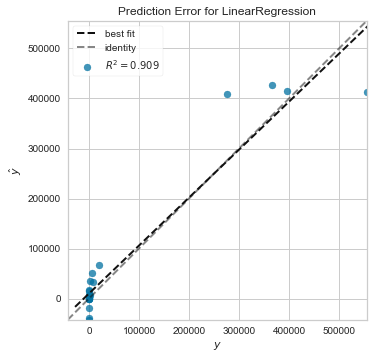

In [47]:
plot_model(lr,'error')

The plot shows us the linear relationship and the best fitted line and the predicted error line for the model.

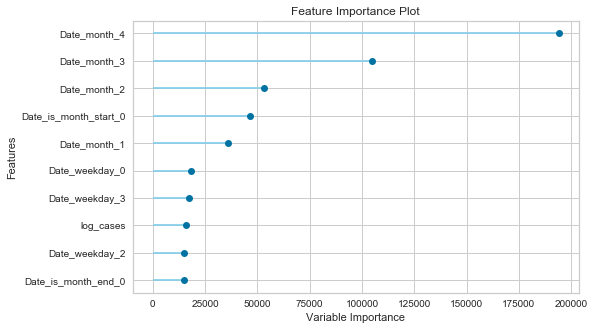

In [48]:
# feature importance plot
plot_model(lr,'feature')

By observing the above plot we can say that the important features for our model is month 4 which is april.

In [49]:
# predict a model
pred_testset = predict_model(lr)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,26875.3591,2.084183e+09,45652.8496,0.9085,4.8927,3524.2296
